# Analyzing Iowa Liquor Sales

## Data Set 

The state of Iowa's Alcoholic Beverages Division [dataset](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy  ) consists of spirit purchase information from January 1, 2012 to current. 

> The Division can provide this level of information because Iowa is one of 17 states that directly controls the sale and distribution of alcoholic beverages https://abd.iowa.gov/division. 

It should be noted that the data set is limited to Iowa Class “E” liquor license which is for:  

> Grocery stores, liquor stores, convenience stores, etc. Allows commercial establishments to sell liquor for off-premises consumption in original unopened containers. No sales by the drink.

Also, while this data set is not direct consumer sales, we can use this information as a proxy indicator of sales because most stores should be only buying spirits that sell well in their stores.  

### Adding the Data Set to MongoDB

I am assuming you have already installed MongoDB but if you haven't you will need to navigate to [MongoDB](https://www.mongodb.org/)  and download the latest version. After installation of MongoDB you will need to follow the next steps and open a connection.

After installation.

Open a command prompt window in the `bin` folder from your `MongoDB` installation and type `mongod`.

![](https://raw.githubusercontent.com/ChristopheHunt/MSDA---Coursework/master/Data%20607/Homework/Project%204/mongod.JPG)

Then in a new command prompt window in the same `bin` folder type `mongo` and continue to create our new collection.

![](https://raw.githubusercontent.com/ChristopheHunt/MSDA---Coursework/master/Data%20607/Homework/Project%204/mongo.JPG)

In [1]:
from pymongo import MongoClient

client = MongoClient()
db = client.test
liquor = db.iowaliquor
liquor.delete_many({})

In [2]:
import numpy as np
import pandas as pd
import datetime
import urllib
import matplotlib
#import plotly
#plotly.offline.init_notebook_mode() 

In [3]:
from sodapy import Socrata
client = Socrata("data.iowa.gov", "ibhJMpvP9MQ1Rl0Ox5wlSMpgn")
results = client.get("spsw-4jax", limit = 100000)
added_results = liquor.insert_many(results)
added_results

In [4]:
list = []
for liquors in liquor.find():
    list.append(liquors)

In [5]:
df = pd.DataFrame(list)
df.columns = ['_id', 'address', 'bottle_volume_ml', 'category', 'category_name',
       'city', 'county', 'county_number', 'date', 'im_desc',
       'invoice_line_no', 'itemno', 'name', 'pack', 'sale_bottles',
       'sale_dollars', 'sale_gallons', 'sale_liters', 'state_bottle_cost',
       'state_bottle_retail', 'store', 'store_location',
       'store_location_address', 'store_location_city',
       'store_location_zip', 'vendor_name', 'vendor_no', 'zipcode']

df['state_bottle_cost'] = df['state_bottle_cost'].astype('float64')
df['bottle_volume_ml'] = df['bottle_volume_ml'].astype('float64')
df['sale_dollars'] = df['sale_dollars'].astype('float64')
df['sale_gallons'] = df['sale_gallons'].astype('float64')

In [6]:
column_subset = df[['category_name', 'county', 'bottle_volume_ml']]
grouped = column_subset.groupby('category_name')
grouped = pd.DataFrame(grouped.sum())
results = grouped.sort_values(by = 'bottle_volume_ml', ascending = False)
results.columns = ['Total Bottle Volume (in ml)']
results.head(10)

,Total Bottle Volume (in ml)
category_name,
VODKA 80 PROOF,14583950.0
CANADIAN WHISKIES,9340975.0
SPICED RUM,5295000.0
STRAIGHT BOURBON WHISKIES,5000025.0
AMERICAN COCKTAILS,4727225.0
BLENDED WHISKIES,4587325.0
WHISKEY LIQUEUR,4504875.0
VODKA FLAVORED,4125300.0
PUERTO RICO & VIRGIN ISLANDS RUM,4020575.0


### Interestingly, we see that Vodka 80 proof and Canadian Whiskies sell at large volumes. I am curious how this translates to the cost of this liquor. I would assume that these are the cheaper liquors which are being sold at high volumes based on personal experience in stores. I typically see the cheaper liquors being sold in large bottles versus the more expensive liquors being sold at smaller volumes  

In [7]:
column_subset = df[['category_name', 'sale_dollars', 'sale_gallons']]
grouped = column_subset.groupby('category_name')
grouped = pd.DataFrame(grouped.sum())
results = pd.DataFrame(grouped.sort_values(by = 'sale_dollars', ascending = False))
results = pd.DataFrame(results['sale_dollars'] / results['sale_gallons'])
results.columns = ['Sale per gallon sold']
results = results.sort_values(by = 'Sale per gallon sold', ascending = True)
results.head(10)

,Sale per gallon sold
category_name,
TRIPLE SEC,17.471847
AMERICAN AMARETTO,26.366995
AMERICAN COCKTAILS,27.089029
SPEARMINT SCHNAPPS,28.191818
TROPICAL FRUIT SCHNAPPS,30.422460
VODKA 80 PROOF,33.518350
WHITE CREME DE MENTHE,33.614457
CREME DE ALMOND,34.007791
ANISETTE,34.244030


### It appears that our top volume sales are not necessarily the cheapest available liquors. While the top liquors by volume are Vodka 80 proof and Canadian Whiskies, we see more mixer type liquors being sold at lower prices per gallon. However, since we do see that Vodka 80 Proof is the most sold liquor by volume and is in the top 10 of cheapest liquors sold in Iowa. Let's explore the sales of Vodka 80 Proof more to see if there are any interesting patterns. 

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import matplotlib.mlab as mlab
import numpy as np
import plotly.plotly as py

import plotly.plotly as py
py.sign_in('chris.edouard.hunt', '4ie1rbxbyt')

In [9]:
client = MongoClient()
db = client.test
liquor = db.iowaliquor
liquor.delete_many({})

from sodapy import Socrata

client = Socrata("data.iowa.gov", "ibhJMpvP9MQ1Rl0Ox5wlSMpgn")
results = client.get("spsw-4jax", where="category='1031080'", limit = 100000)
added_results = liquor.insert_many(results)

We us "where="category='1031080'"" because 1031080 is the Category ID for Vodka 80 Proof

In [10]:
list = []
for liquors in liquor.find():
    list.append(liquors)

In [11]:
df = pd.DataFrame(list)
df.columns = ['_id', 'address', 'bottle_volume_ml', 'category', 'category_name',
       'city', 'county', 'county_number', 'date', 'im_desc',
       'invoice_line_no', 'itemno', 'name', 'pack', 'sale_bottles',
       'sale_dollars', 'sale_gallons', 'sale_liters', 'state_bottle_cost',
       'state_bottle_retail', 'store', 'store_location',
       'store_location_address', 'store_location_city',
       'store_location_zip', 'vendor_name', 'vendor_no', 'zipcode']

df['state_bottle_cost'] = df['state_bottle_cost'].astype('float64')
df['bottle_volume_ml'] = df['bottle_volume_ml'].astype('float64')
df['sale_dollars'] = df['sale_dollars'].astype('float64')
df['sale_gallons'] = df['sale_gallons'].astype('float64')
df['date'] = pd.to_datetime(df['date'])

In [12]:
top_n_countries = 5
top_counties = df[['county', 'sale_gallons']]
top_counties = top_counties.groupby(["county"]).sum().sort_values(by = 'sale_gallons', ascending = False).head(top_n_countries).index.values.tolist()
pd.DataFrame(top_counties)

,0
0,Polk
1,Linn
2,Scott
3,Dubuque
4,Black Hawk


We will look at the top 5 counties and the volume of VODKA 80 PROOF sales over the time period of the data set. Polk County is a the top of our list but that should not be suprising as that is the largest county by population in Iowa. 

In [13]:
vodka_column_subset = df[['sale_gallons', 'county', 'date']]
vodka_column_subset = vodka_column_subset[vodka_column_subset['county'].isin(top_counties)]
vodka_column_subset['date'] =  pd.to_datetime(vodka_column_subset['date'], format = "%m/%d/%Y")
vodka_column_subset = vodka_column_subset.set_index('date')
grouped = vodka_column_subset.groupby(["county", pd.TimeGrouper('M')]).sum()
grouped

sale_gallons
county     date                    
Black Hawk 2012-01-31   2578.556986
           2012-02-29    301.836383
           2012-03-31    279.203442
           2012-04-30    363.546974
           2012-05-31    351.982843
           2012-06-30    423.903684
           2012-07-31    393.484272
           2012-08-31    368.361510
           2012-09-30    216.376724
           2012-10-31    417.616389
           2012-11-30    313.625061
           2012-12-31    386.516734
           2013-01-31    255.011886
           2013-02-28    234.406466
           2013-03-31    262.705897
           2013-04-30    383.683489
           2013-05-31    260.533082
           2013-06-30    347.683442
           2013-07-31    383.181562
           2013-08-31    348.191974
           2013-09-30    399.064907
           2013-10-31    324.370259
           2013-11-30    269.026214
           2013-12-31    393.622962
           2014-01-31    294.261249
           2014-02-28    267.698749
           2014-03-31    261.008592
           2014-04-30    321.695517
           2014-05-31    298.336103
           2014-06-30    389.178268
...                             ...
Scott      2013-09-30    484.346249
           2013-10-31    869.469476
           2013-11-30    396.852466
           2013-12-31    600.661204
           2014-01-31    488.493751
           2014-02-28    612.958413
           2014-03-31    571.034308
           2014-04-30    693.121422
           2014-05-31    458.582870
           2014-06-30    563.043104
           2014-07-31    732.780252
           2014-08-31    500.374889
           2014-09-30    573.814719
           2014-10-31    922.554850
           2014-11-30    416.533284
           2014-12-31    644.302427
           2015-01-31    408.218468
           2015-02-28    445.182743
           2015-03-31    505.981940
           2015-04-30    557.687015
           2015-05-31    484.399084
           2015-06-30    607.991979
           2015-07-31    519.500945
           2015-08-31    540.707357
           2015-09-30    657.002499
           2015-10-31    501.028715
           2015-11-30    502.752437
           2015-12-31    753.055457
           2016-01-31    431.287293
           2016-02-29    379.714304

[253 rows x 1 columns]

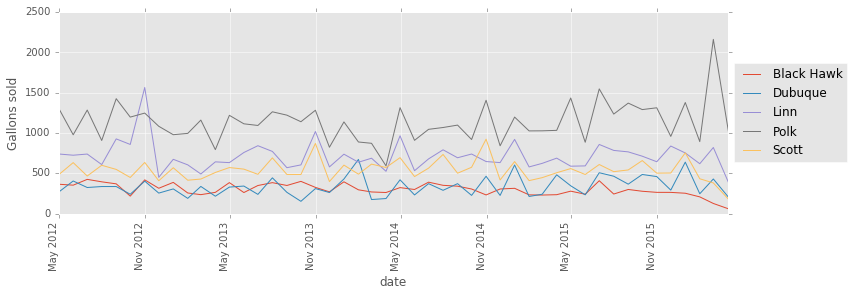

In [14]:
plotting = grouped.unstack().fillna(0).transpose().unstack(level=0)
plotting.columns = plotting.columns.droplevel(1)

fig = plt.figure()
ax = plotting.unstack().fillna(0).transpose().unstack(level=0).plot()

#legend help from http://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 2, box.height])
ax.set_xlim(pd.Timestamp('2012-04-30'), pd.Timestamp('2016-04-01'))
ax.set_ylim(0,2500)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation='vertical')
plt.xlabel("date")
plt.ylabel("Gallons sold")

plt.show()

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import os


# the map, a Miller Cylindrical projection
m = Basemap(projection='mill',
            llcrnrlon=-180. ,llcrnrlat=-60,
            urcrnrlon=180. ,urcrnrlat=80.)

s = m.readshapefile( "\\cb_2015_us_county_20m", 'cb_2015_us_county_20m')

plt.show()

OSError: cannot locate \cb_2015_us_county_20m.shp

In [56]:
import fiona

'C:\\Users\\Christophe\\Documents\\GitHub\\MSDA - Coursework\\Data 602\\Data 602 - Advanced Programming\\Final Project'

In [9]:
for sale in liquor.find({"city" : "IOWA CITY"}):
 print(sale)